In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from hyperopt import hp, tpe, fmin, Trials
from tqdm import tqdm
# from tqdm.notebook import tqdm

from collections import OrderedDict, defaultdict
import itertools
from functools import partial
import datetime
from joblib import Parallel, delayed
import copy
import json

from data.dataloader import get_jhu_data, get_covid19india_api_data, get_rootnet_api_data
from data.processing import get_data, get_district_time_series

from models.seir.seir_testing import SEIR_Testing
from main.seir.optimiser import Optimiser
from main.seir.losses import Loss_Calculator
from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, create_region_csv, create_all_csvs, write_csv, plot_forecast

## Load Covid19india Data

In [9]:
dataframes = get_covid19india_api_data()

In [6]:
predictions_dict = {}

## Select Districts to fit on

In [7]:
districts_to_show = [('Maharashtra', 'Pune'), 
                     ('Maharashtra', 'Mumbai'), 
                     ('Rajasthan', 'Jaipur'), 
                     ('Gujarat', 'Ahmedabad'), 
                     ('Karnataka', 'Bengaluru Urban'),
                     ('Delhi', None)]

districts_to_show = [('Maharashtra', 'Pune')]

## Perform M1 and M2 fits

fitting to data with "train_on_val" set to False ..
splitting data ..
splitting data ..
train
          date        state district  total_infected  hospitalised  recovered  \
16 2020-05-07  Maharashtra     Pune          2148.6        1352.4      670.2   
17 2020-05-08  Maharashtra     Pune          2256.4        1356.6      767.2   
18 2020-05-09  Maharashtra     Pune          2365.2        1358.8      867.6   
19 2020-05-10  Maharashtra     Pune          2483.4        1363.2      975.2   
20 2020-05-11  Maharashtra     Pune          2599.2        1344.6     1104.2   

    deceased  
16     126.0  
17     132.6  
18     138.8  
19     145.0  
20     150.4  
val
         date        state district  total_infected  hospitalised  recovered  \
0 2020-05-12  Maharashtra     Pune          2720.6        1328.2     1236.2   
1 2020-05-13  Maharashtra     Pune          2842.8        1322.4     1358.2   
2 2020-05-14  Maharashtra     Pune          2987.2        1337.8     1480.0   
3 2020-05-15 

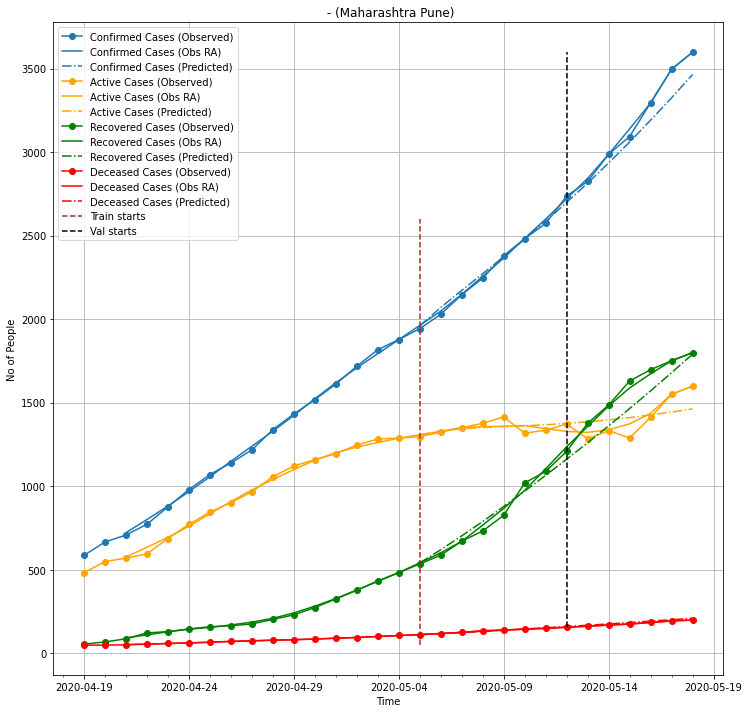

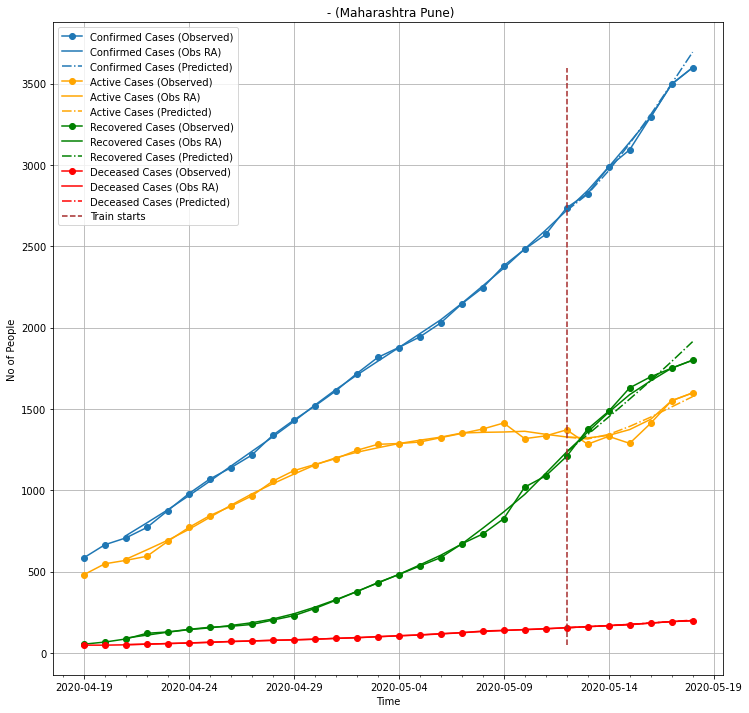

In [11]:
for state, district in districts_to_show:
    predictions_dict[(state, district)] = {}
    predictions_dict[(state, district)]['m1'] = single_fitting_cycle(dataframes, state, district, train_period=7, val_period=7, 
                                                                     data_from_tracker=False, filename="../../data/data/official-pune-21-05-20.csv", initialisation='intermediate', num_evals=2000,
                                                                     which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])
    predictions_dict[(state, district)]['m2'] = single_fitting_cycle(dataframes, state, district, train_period=7, val_period=0, num_evals=2000,
                                                                     train_on_val=True, data_from_tracker=False, filename="../../data/data/official-pune-21-05-20.csv",initialisation='intermediate',
                                                                     which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])

In [ ]:
for state, district in districts_to_show:
    predictions_dict[(state, district)] = {}
    predictions_dict[(state, district)]['m1'] = single_fitting_cycle(dataframes, state, district, train_period=7, val_period=7, num_evals=1000,
                                                                     data_from_tracker=False, filename='../../data/data/official-mumbai.csv', 
                                                                     initialisation='intermediate',
                                                                     which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])
    predictions_dict[(state, district)]['m2'] = single_fitting_cycle(dataframes, state, district, train_period=7, val_period=0, num_evals=1000,
                                                                     data_from_tracker=False, filename='../../data/data/official-mumbai.csv',
                                                                     initialisation='intermediate', train_on_val=True, 
                                                                     which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])

## Create Master Loss Dataframe

### M1 Loss

In [12]:
starting_key = list(predictions_dict.keys())[0]

loss_columns = pd.MultiIndex.from_product([predictions_dict[starting_key]['m1']['df_loss'].columns, predictions_dict[starting_key]['m1']['df_loss'].index])
loss_index = predictions_dict.keys()

df_loss_master = pd.DataFrame(columns=loss_columns, index=loss_index)
for key in predictions_dict.keys():
    df_loss_master.loc[key, :] = np.around(predictions_dict[key]['m1']['df_loss'].values.T.flatten().astype('float'), decimals=2)
    
df_loss_master

train                                            val  \
                 hospitalised total_infected deceased recovered hospitalised   
Maharashtra Pune         1.93           0.87     1.45      4.51         5.53   

                                                    
                 total_infected deceased recovered  
Maharashtra Pune           2.41     4.05      6.64

### M2 Loss

In [13]:
starting_key = list(predictions_dict.keys())[0]

loss_columns = pd.MultiIndex.from_product([predictions_dict[starting_key]['m2']['df_loss'].columns, predictions_dict[starting_key]['m2']['df_loss'].index])
loss_index = predictions_dict.keys()

df_loss_master = pd.DataFrame(columns=loss_columns, index=loss_index)
for key in predictions_dict.keys():
    df_loss_master.loc[key, :] = np.around(predictions_dict[key]['m2']['df_loss'].values.T.flatten().astype('float'), decimals=2)
    
df_loss_master

train                                  
                 hospitalised total_infected deceased recovered
Maharashtra Pune         2.97           0.83     0.61      3.03

## Plot Forecasts

getting forecasts ..


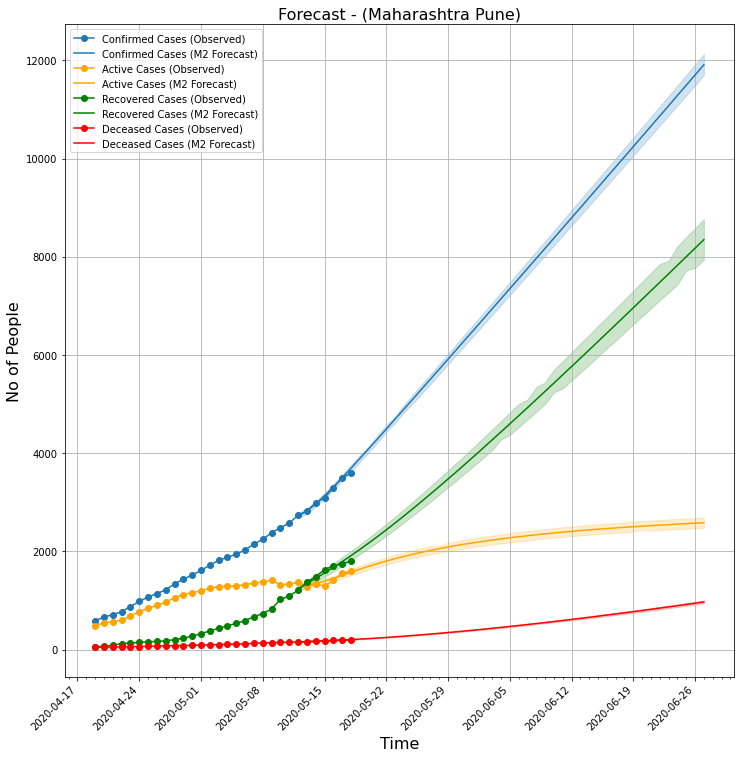

In [29]:
for region in predictions_dict.keys():
    plot_forecast(predictions_dict[region], region, both_forecasts=False, error_bars=True)

getting forecasts ..
getting forecasts ..


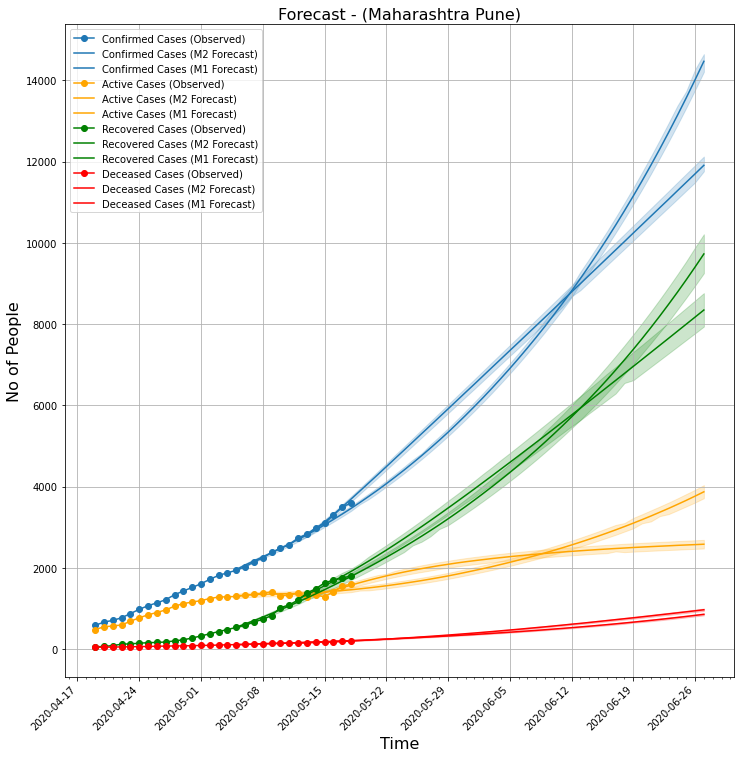

In [28]:
for region in predictions_dict.keys():
    plot_forecast(predictions_dict[region], region, both_forecasts=True, error_bars=True)

## Create and Save Output CSV

In [15]:
df_output = create_all_csvs(predictions_dict, initialisation='intermediate', train_period=7, icu_fraction=0.02)

compiling csv data ..
getting forecasts ..


In [17]:
write_csv(df_output, '../../output-{}.csv'.format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

In [22]:
starting_key=list(predictions_dict.keys())[0]

In [23]:
predictions_dict[starting_key]

{'m1': {'best_params': {'E_hosp_ratio': 0.2889124899673495,
   'I_hosp_ratio': 0.41230918087584145,
   'P_fatal': 0.1015404310833966,
   'P_severe': 0.5777083302245327,
   'T_inc': 4.805085752239212,
   'T_inf': 3.2027441766646056,
   'T_recov_severe': 14.700432791733078,
   'lockdown_R0': 1.2403201827202166},
  'default_params': {'N': 10000000.0,
   'init_infected': 0,
   'lockdown_day': -41,
   'lockdown_removal_day': 26,
   'T_hosp': 0.001,
   'starting_date': Timestamp('2020-05-05 00:00:00')},
  'optimiser': <main.seir.optimiser.Optimiser at 0x11be2dd90>,
  'df_prediction':          date        S    E    I  D_E  D_I  R_mild  R_severe_home  \
  0  2020-05-05  9997119  378  539    0    0       0              0   
  1  2020-05-06  9996925  482  472    0    0      48              0   
  2  2020-05-07  9996749  549  439    0    0      87              0   
  3  2020-05-08  9996582  597  423    0    0     121              0   
  4  2020-05-09  9996419  632  420    0    0     150          

## Create Multiple Forecasts For Top 10 Param Sets

In [48]:
losses_array = np.array([trial['result']['loss'] for trial in predictions_dict[starting_key]['m2']['trials']])
least_losses_indices = np.argsort(losses_array)
np.sort(losses_array)

array([4.11461978e+00, 4.20051267e+00, 4.21943240e+00, ...,
       1.00000000e+10, 1.00000000e+10, 1.00000000e+10])

In [50]:
np.sort(losses_array)[1:100]

array([4.20051267, 4.2194324 , 4.22029072, 4.27117027, 4.32301782,
       4.33373778, 4.37026453, 4.37183447, 4.37349827, 4.40071251,
       4.40578799, 4.43299531, 4.46385576, 4.47647582, 4.56403649,
       4.65577499, 4.67205101, 4.70137605, 4.70825964, 4.71032305,
       4.73563958, 4.76667751, 4.77002322, 4.88413671, 4.88464226,
       4.93440528, 4.93513853, 4.94159939, 4.94350319, 4.99141401,
       5.00348238, 5.02453149, 5.02985631, 5.0533388 , 5.06442337,
       5.06553901, 5.10611374, 5.1401164 , 5.14078397, 5.15127126,
       5.17069334, 5.18772948, 5.19910431, 5.20322331, 5.21176432,
       5.2586164 , 5.34528151, 5.38128574, 5.39455188, 5.40849877,
       5.42009229, 5.43218263, 5.43873404, 5.44556169, 5.47906186,
       5.4843768 , 5.48539436, 5.48566845, 5.48862745, 5.49373112,
       5.52291278, 5.52719901, 5.53077868, 5.54278236, 5.56100843,
       5.56266329, 5.56519813, 5.56657345, 5.59425615, 5.60458999,
       5.62029447, 5.62246683, 5.66048292, 5.68651773, 5.68713

In [51]:
params_array = []
for trial in predictions_dict[starting_key]['m2']['trials']:
    params_dict = copy.copy(trial['misc']['vals'])
    for key in params_dict.keys():
        params_dict[key] = params_dict[key][0]
    params_array.append(params_dict)

params_array = np.array(params_array)

In [52]:
np.sort(losses_array)[:10]

array([4.11461978, 4.20051267, 4.2194324 , 4.22029072, 4.27117027,
       4.32301782, 4.33373778, 4.37026453, 4.37183447, 4.37349827])

In [53]:
predictions_array = [get_forecast(predictions_dict[starting_key], best_params=params_dict) for params_dict in params_array[least_losses_indices[:10]]]

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..


In [57]:
params_dict = params_array[least_losses_indices[:10]]
params_dict

array([{'E_hosp_ratio': 0.9757633582409255, 'I_hosp_ratio': 0.2127294093705905, 'P_fatal': 0.15446400718308245, 'P_severe': 0.8322813663058146, 'T_inc': 4.1208394426042885, 'T_inf': 3.665368141964045, 'T_recov_severe': 10.281446096017044, 'lockdown_R0': 1.0065189740757183},
       {'E_hosp_ratio': 1.0375841756664075, 'I_hosp_ratio': 0.23501935054295875, 'P_fatal': 0.14267755101342494, 'P_severe': 0.772436191048898, 'T_inc': 4.177119028651801, 'T_inf': 3.728128389547127, 'T_recov_severe': 10.582903106271987, 'lockdown_R0': 1.006943997806274},
       {'E_hosp_ratio': 1.103930232214451, 'I_hosp_ratio': 0.1652340640041325, 'P_fatal': 0.1458467664105906, 'P_severe': 0.8152587687286854, 'T_inc': 4.132763567126715, 'T_inf': 3.708702820742562, 'T_recov_severe': 10.699430231775516, 'lockdown_R0': 1.0179473918117394},
       {'E_hosp_ratio': 0.9576260785937137, 'I_hosp_ratio': 0.22139351020347003, 'P_fatal': 0.14883974437348493, 'P_severe': 0.8100005981421262, 'T_inc': 4.074663098858895, 'T_inf'

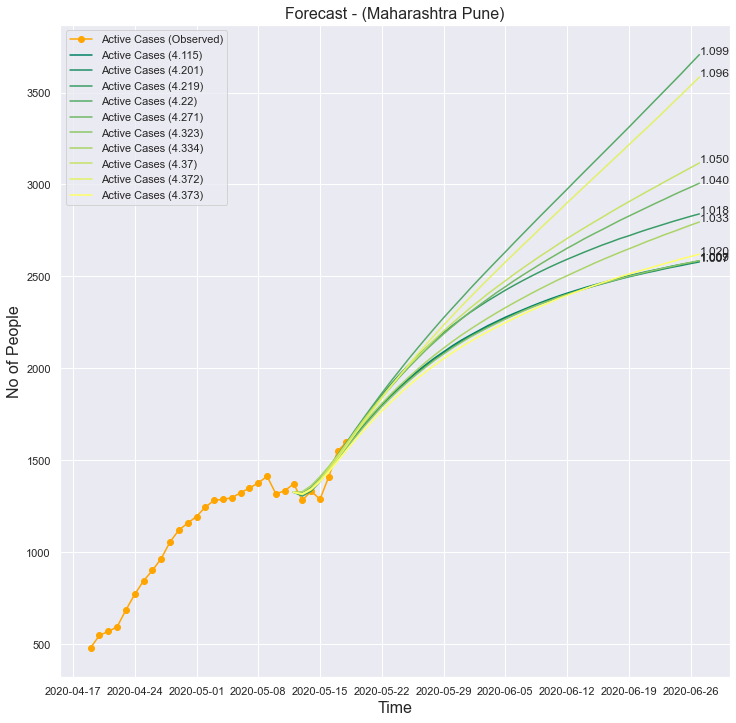

In [71]:
df_true = predictions_dict[starting_key]['m2']['df_district']
color_idx=np.linspace(0,1,10)
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(df_true['date'], df_true['hospitalised'],
        '-o', color='orange', label='Active Cases (Observed)')
for i, df_prediction in enumerate(predictions_array):
    loss_value = np.around(np.sort(losses_array)[:10][i], 3)
    params_dict = params_array[least_losses_indices[:10]]
    true_r0 = np.around(params_dict[i]['lockdown_R0'], 3)
    if true_r0 > 1.7:
        continue
    sns.lineplot(x="date", y="hospitalised", data=df_prediction,
                 ls='-', color=plt.cm.summer(color_idx[i]), label='Active Cases ({})'.format(loss_value))
    plt.text(x=df_prediction['date'].iloc[-1], y=df_prediction['hospitalised'].iloc[-1], s="{0:.3f}".format(true_r0))
    
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.ylabel('No of People', fontsize=16)
# plt.yscale('log')
plt.xlabel('Time', fontsize=16)
plt.legend()
plt.title('Forecast - ({} {})'.format(region[0], region[1]), fontsize=16)
plt.grid(True)
plt.show()  